# importing libraries

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import datetime as dt
import urllib.request, json
import os
from sklearn.preprocessing import MinMaxScaler


# Utility Function - Download reqd csv

In [2]:
def download_and_ret_df(ticker):

    data_source = 'alphavantage' # alphavantage or kaggle

    if data_source == 'alphavantage':
        # ====================== Loading Data from Alpha Vantage ==================================

        api_key = '2KD8FZPAQ5VWR9MO'

        # American Airlines stock market prices
        ticker = ticker

        # JSON file with all the stock market data for AAL from the last 20 years
        url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

        # Save data to this file
        file_to_save = 'stock_market_data-%s.csv'%ticker

        # If you haven't already saved data,
        # Go ahead and grab the data from the url
        # And store date, low, high, volume, close, open values to a Pandas DataFrame
        if os.path.exists(file_to_save):
            with urllib.request.urlopen(url_string) as url:
                data = json.loads(url.read().decode())
                # extract stock market data
                data = data['Time Series (Daily)']
                df = pd.DataFrame(columns=['Date','Low','High','Close','Open'])
                for k,v in data.items():
                    date = dt.datetime.strptime(k, '%Y-%m-%d')
                    data_row = [date.date(),float(v['3. low']),float(v['2. high']),
                                float(v['4. close']),float(v['1. open'])]
                    df.loc[-1,:] = data_row
                    df.index = df.index + 1
            print('Data saved to : %s'%file_to_save)        
            df.to_csv(file_to_save)
            
            return file_to_save

In [3]:
file_to_save = download_and_ret_df('AAL')
df1 = pd.read_csv(file_to_save,names=['ind','date','low','high','close','open'])
df1.head()

df1 = df1.drop(axis=0,columns=['ind','date'])
df1 = df1.drop(df1.index[0])

df1 = df1.reindex(columns=['open','low','high','close'])
df1.head()

Data saved to : stock_market_data-AAL.csv


,open,low,high,close
1,36.59,35.64,37.46,36.33
2,35.3,35.07,36.47,36.37
3,35.16,34.81,35.9,35.08
4,32.44,32.33,34.78,34.66
5,33.14,31.95,33.995,32.6


# Plotting Graphs

open_values = df1["open"].values
plt.plot(open_values)
plt.show()

In [4]:
df = df1.transpose()
df.to_csv("tester.csv",float_format=np.float32)
df = pd.read_csv("tester.csv",index_col=0)
#df.drop(axis=0,columns=['Unnamed: 0'])
df.head()

,1,2,3,4,5,6,7,8,9,10,...,3291,3292,3293,3294,3295,3296,3297,3298,3299,3300
open,36.59,35.30,35.16,32.44,33.140,31.40,31.19,32.48,31.53,32.27,...,22.28,22.25,22.60,22.10,21.44,20.90,20.26,20.40,19.30,21.05
low,35.64,35.07,34.81,32.33,31.950,31.30,31.12,30.24,30.60,31.82,...,22.10,21.80,22.40,21.75,21.44,20.90,20.18,20.10,19.20,19.10
high,37.46,36.47,35.90,34.78,33.995,33.01,33.33,32.75,32.44,32.52,...,22.29,22.60,23.00,22.31,22.50,21.75,21.05,20.58,20.53,21.40
close,36.33,36.37,35.08,34.66,32.600,32.46,32.37,30.34,32.38,32.16,...,22.21,22.15,22.58,22.20,22.16,21.50,21.01,20.21,20.50,19.30


# Setting Parameters

In [5]:
# total = n-1
# batch size = 30% of total

batch_size = int(0.02*(df.shape[1]-1))
batch_size

65

In [6]:
epoch = int(df.shape[1]/(0.02*(df.shape[1])))
epoch

50

# placeholders

In [7]:
tX = tf.placeholder(dtype=tf.float32, shape=(None,None))
tY = tf.placeholder(dtype=tf.float32, shape=(None))

# Nodes

In [8]:
n_features = batch_size-1
n_hidden_1 = 128
n_hidden_2 = 4
n_hidden_3 = 4
n_out = 1

# weights and bias

In [9]:
weights = {
    'h1':tf.Variable(np.ndarray.astype(np.random.uniform(high=.2,low=0,size=(n_features,n_hidden_1)),np.float32)),
    'h2':tf.Variable(np.ndarray.astype(np.random.uniform(high=.001,low=0,size=(n_hidden_1,n_hidden_2)),np.float32)),
    'h3':tf.Variable(np.ndarray.astype(np.random.uniform(high=1,low=0,size=(n_hidden_2,n_hidden_3)),np.float32)),
    'out':tf.Variable(np.ndarray.astype(np.random.uniform(high=.001,low=0,size=(n_hidden_3,n_out)),np.float32))
}

biases = {
    'h1':tf.Variable(tf.ones([n_hidden_1])),
    'h2':tf.Variable(tf.zeros([n_hidden_2])),
    'h3':tf.Variable(tf.ones([n_hidden_3])),
    'out':tf.Variable(tf.ones([n_out]))
}

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    np.savetxt("weights1.csv",sess.run(weights['h1']),delimiter=',')
    np.savetxt("weights2.csv",sess.run(weights['h2']),delimiter=',')
    np.savetxt("weights3.csv",sess.run(weights['out']),delimiter=',')
    

# network

In [10]:
def network(x):
    hidden1 =tf.nn.leaky_relu(tf.add(tf.matmul(x,weights['h1']),biases['h1']))
    hidden2 =tf.nn.leaky_relu(tf.add(tf.matmul(hidden1,weights['h2']),biases['h2']))
    #hidden3 =tf.nn.leaky_relu(tf.add(tf.matmul(hidden2,weights['h3']),biases['h3']))
    out_op = tf.nn.leaky_relu(tf.add(tf.matmul(hidden2,weights['out']),biases['out']))
    
    return out_op

In [11]:
logits = network(tX)

In [12]:
def splitter(df,batch_size,total_size):
    
    start = 0
    
    X_test = df.iloc(axis=1)[0:, start+1:batch_size].values
    
    Y_test = df.iloc(axis=1)[0:, start:start+1].values
    
    
    #X_test,Y_test = converter_values_float(X_test,Y_test)
    
    #print("X_test matrix\n", X_test.shape,"\n",X_test)
    #print("Y_test matrix\n", Y_test.shape,"\n",Y_test)
    
    rem = df.shape[1]-batch_size
    #print("Rem = ",rem)
    # remaining data will be treated as train
    #print(df.iloc[0:,batch_size:])
    
    X_train_list = list()
    Y_train_list = list()
    
    for i in range(int(rem//batch_size)):
        
        start2 = batch_size
        extend = start2*(i+1) + batch_size
        X_train = df.iloc[0:,(start2)*(i+1):extend-1].values
        
        X_train_list.append(X_train)
        
        Y_train = df.iloc[0:, start2*(i+1):start2*(i+1)+1].values
        
        Y_train_list.append(Y_train)
        
    #print(X_train_list)
    #print(Y_train_list)
    #convert_train_values_float(X_train_list,Y_train_list)
    
    
    return (X_train_list,X_test, Y_train_list,Y_test)
    
    

total_size = df.shape[1]
X_train,X_test, Y_train,Y_test=splitter(df,batch_size,total_size)
X_test_final = df.iloc[0:,0:batch_size-1].values


#Y,X test
#Y,X train
X_train = np.asarray(X_train,dtype=np.float32)
Y_train = np.asarray(Y_train,dtype=np.float32)
print("************\nX_train\n",X_train)
print("************\nX_test\n",X_test)
print("************\nY_train\n",Y_train)
print("************\nY_test\n",Y_test)
print("************\nTo Be Predicted\n",X_test_final)

************
X_train
 [[[37.86   39.38   39.26   ... 42.92   41.75   42.25  ]
  [37.35   37.69   39.14   ... 42.1235 41.75   41.54  ]
  [38.12   39.47   39.87   ... 43.23   43.45   42.49  ]
  [37.93   38.14   39.54   ... 42.44   42.86   42.11  ]]

 [[42.86   43.5    42.55   ... 54.     53.08   52.45  ]
  [42.56   42.76   42.325  ... 53.59   53.     52.36  ]
  [43.46   43.81   43.48   ... 54.64   54.71   53.05  ]
  [43.36   42.93   43.4    ... 53.88   54.32   52.59  ]]

 [[53.65   54.     54.35   ... 48.41   52.     51.78  ]
  [52.34   52.21   53.45   ... 47.33   48.32   50.61  ]
  [53.9    54.55   55.46   ... 48.89   53.19   51.78  ]
  [53.07   53.05   54.79   ... 47.56   48.61   51.02  ]]

 ...

 [[46.77   44.9    45.     ... 46.65   45.55   45.49  ]
  [45.6    44.65   44.36   ... 46.6    45.55   45.1   ]
  [47.44   46.78   46.64   ... 47.7    46.75   47.7   ]
  [46.23   46.53   44.9    ... 47.47   46.47   45.2   ]]

 [[41.8    44.15   47.6    ... 35.15   35.2    34.28  ]
  [41.29   4

# optimise

In [13]:
#loss_op = cost = tf.reduce_sum(tf.pow(logits-tY, 2))/(2*batch_size)
loss_op = tf.reduce_sum(tf.pow(logits-tY, 2))/(2*batch_size)
optimiser = tf.train.AdamOptimizer(learning_rate=0.05).minimize(loss_op)

# Session

EPOCH:  1  LOSS:  41.635853
EPOCH:  2  LOSS:  10837.548
EPOCH:  3  LOSS:  11.347628
EPOCH:  4  LOSS:  60.382336
EPOCH:  5  LOSS:  15.458859
EPOCH:  6  LOSS:  0.27142
EPOCH:  7  LOSS:  1.7809771
EPOCH:  8  LOSS:  12.872153
EPOCH:  9  LOSS:  25.690859
EPOCH:  10  LOSS:  72.50051
EPOCH:  11  LOSS:  120.89037
EPOCH:  12  LOSS:  152.26027
EPOCH:  13  LOSS:  239.88567
EPOCH:  14  LOSS:  418.34396
EPOCH:  15  LOSS:  379.17438
EPOCH:  16  LOSS:  330.36862
EPOCH:  17  LOSS:  343.83643
EPOCH:  18  LOSS:  248.61531
EPOCH:  19  LOSS:  108.85026
EPOCH:  20  LOSS:  59.742306
EPOCH:  21  LOSS:  53.52166
EPOCH:  22  LOSS:  32.58493
EPOCH:  23  LOSS:  21.682938
EPOCH:  24  LOSS:  19.185701
EPOCH:  25  LOSS:  9.5843
EPOCH:  26  LOSS:  5.015544
EPOCH:  27  LOSS:  2.0098252
EPOCH:  28  LOSS:  2.9559538
EPOCH:  29  LOSS:  4.1299767
EPOCH:  30  LOSS:  3.0335886
EPOCH:  31  LOSS:  1.8006481
EPOCH:  32  LOSS:  0.62987334
EPOCH:  33  LOSS:  0.0023773771
EPOCH:  34  LOSS:  0.29284748
EPOCH:  35  LOSS:  0.673329

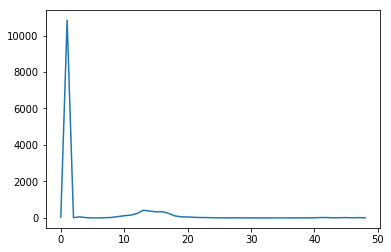

In [14]:
loss_array = []
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # train
    
    for i in range(epoch-1):
        _,l = sess.run([optimiser,loss_op],feed_dict={tX:X_train[i],tY:Y_train[i]})
        # find proper loss function
        print("EPOCH: ",i+1," LOSS: ",l)
        loss_array.append(l)
    print(min(loss_array))
    # test
    final_op_test = logits.eval(feed_dict={tX:X_test})
    print(final_op_test)
    
    # accuracy
    accuracy = []
    deviation = np.absolute(Y_test-final_op_test)
    for j in range(4):
        accuracy.append(float(100-(deviation[j]/Y_test[j])*100))
    
        print("PREDICTED :",final_op_test[j],"ACTUAL: ",Y_test[j]," ACCURACY: ",accuracy[j])
        
    

    # final prediction batch
    final_pred = logits.eval(feed_dict={tX:X_test_final})
    print("FINAL PREDICTION\n",final_pred)
plt.plot(loss_array)